In [46]:
# 1. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

In [47]:
# 2. Load data
# Using the historicized municipality dataset (monthly snapshots)
df = pd.read_csv(r"C:\Users\peter\OneDrive\Рабочий стол\Portfolio Project 1\data\energyreporter_municipality_historized.csv")

In [48]:
# Original observations
print("=== RAW DF INFO ===")
df.info()
print("=== RAW DF HEAD ===")
print(df.head(), "\n")

=== RAW DF INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111360 entries, 0 to 111359
Data columns (total 35 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   bfs_nr                                               111360 non-null  int64  
 1   municipality                                         111360 non-null  object 
 2   canton                                               111360 non-null  object 
 3   bfs_municipality_type_2012_25                        111360 non-null  int64  
 4   energyreporter_date                                  111360 non-null  object 
 5   electric_car_share                                   111360 non-null  float64
 6   electric_car_count                                   111360 non-null  int64  
 7   electric_car_share_last_change                       111360 non-null  object 
 8   electric_car_charging_spot_count  

In [49]:
# 3. Subset to solar-relevant columns into solar_df
solar_df = df[[
    "energyreporter_date",
    "municipality",
    "canton",
    "solar_potential_usage",
    "solar_power_installed_kwp",
    "solar_potential_usage_last_change"
]].copy()
print("=== SOLAR_DF HEAD ===")
print(solar_df.head(), "\n")

=== SOLAR_DF HEAD ===
  energyreporter_date     municipality canton  solar_potential_usage  \
0          2021-03-31  Aeugst am Albis     ZH               0.067674   
1          2021-04-30  Aeugst am Albis     ZH               0.067674   
2          2021-05-31  Aeugst am Albis     ZH               0.071489   
3          2021-06-30  Aeugst am Albis     ZH               0.071489   
4          2021-07-31  Aeugst am Albis     ZH               0.071913   

   solar_power_installed_kwp solar_potential_usage_last_change  
0                        958                        2020-10-13  
1                        958                        2020-10-13  
2                       1012                        2020-11-11  
3                       1012                        2020-11-11  
4                       1018                        2020-11-11   



In [50]:
# Total number of unique municipalities
total_municipalities = solar_df['municipality'].nunique()
print(f"Total municipalities: {total_municipalities}")


Total municipalities: 2184


In [51]:
# 4. Convert date column for time-series
# Dates are in ISO format yyyy-mm-dd, let pandas infer
solar_df["energyreporter_date"] = pd.to_datetime(solar_df["energyreporter_date"], infer_datetime_format=True)
print("=== SOLAR_DF INFO AFTER DATE CONVERSION ===")
print(solar_df.info())

=== SOLAR_DF INFO AFTER DATE CONVERSION ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111360 entries, 0 to 111359
Data columns (total 6 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   energyreporter_date                111360 non-null  datetime64[ns]
 1   municipality                       111360 non-null  object        
 2   canton                             111360 non-null  object        
 3   solar_potential_usage              111360 non-null  float64       
 4   solar_power_installed_kwp          111360 non-null  int64         
 5   solar_potential_usage_last_change  111354 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 5.1+ MB
None


C:\Users\peter\AppData\Local\Temp\ipykernel_12932\256020972.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  solar_df["energyreporter_date"] = pd.to_datetime(solar_df["energyreporter_date"], infer_datetime_format=True)


In [52]:
# 5. Clean data: drop rows with missing usage or capacity Clean data: drop rows with missing usage or capacity
before = len(solar_df)

df_clean = solar_df.dropna(
    subset=["solar_potential_usage", "solar_power_installed_kwp"]
).reset_index(drop=True)
after = len(df_clean)
print(f"Dropped {before - after} rows with missing metrics\n")

Dropped 0 rows with missing metrics



In [53]:
# 6. Sort and reset index for consistency
df_clean.sort_values(
    ["municipality", "energyreporter_date"], inplace=True
)
df_clean.reset_index(drop=True, inplace=True)

In [54]:
# 7. Compute unused solar potential
# fraction of unused capacity
df_clean["unused_solar_potential"] = 1 - df_clean["solar_potential_usage"]

In [55]:
df_clean.head(10)

,energyreporter_date,municipality,canton,solar_potential_usage,solar_power_installed_kwp,solar_potential_usage_last_change,unused_solar_potential
0,2021-03-31,Aadorf,TG,0.038049,2573,2020-10-28,0.961951
1,2021-04-30,Aadorf,TG,0.038049,2573,2020-10-28,0.961951
2,2021-05-31,Aadorf,TG,0.055468,3751,2021-01-06,0.944532
3,2021-06-30,Aadorf,TG,0.058618,3964,2021-03-10,0.941382
4,2021-07-31,Aadorf,TG,0.062374,4218,2021-06-09,0.937626
5,2021-08-31,Aadorf,TG,0.062374,4218,2021-06-09,0.937626
6,2021-09-30,Aadorf,TG,0.063794,4314,2021-06-24,0.936206
7,2021-10-31,Aadorf,TG,0.066219,4478,2021-06-24,0.933781
8,2021-11-30,Aadorf,TG,0.066456,4494,2021-06-24,0.933544
9,2021-12-31,Aadorf,TG,0.068201,4612,2021-11-04,0.931799


In [56]:
df_clean.describe()

,energyreporter_date,solar_potential_usage,solar_power_installed_kwp,unused_solar_potential
count,111360,111360.000000,111360.000000,111360.000000
mean,2023-05-13 12:18:31.034482688,0.067276,1977.425862,0.932724
min,2021-03-31 00:00:00,0.000000,0.000000,-1.000000
25%,2022-03-31 00:00:00,0.037998,402.000000,0.912769
50%,2023-04-30 00:00:00,0.058671,1003.000000,0.941329
75%,2024-05-31 00:00:00,0.087231,2355.250000,0.962002
max,2025-06-30 00:00:00,2.000000,73464.000000,1.000000
std,NaN,0.044750,3014.114439,0.044750


### Observations from .describe()
- The data spans over 4 years, from March 2021 to June 2025.
- The date rage includes future months: worth investigating.
- Most municipalities use <10% of their potential.
- Some values exceed 100% usage: outliers worth inspecting.

In [57]:
# Checking the rows after the last uploaded date (202.03.11)
df_clean[df_clean['energyreporter_date'] > '2024-03-11']

,energyreporter_date,municipality,canton,solar_potential_usage,solar_power_installed_kwp,solar_potential_usage_last_change,unused_solar_potential
36,2024-03-31,Aadorf,TG,0.105788,8757,2024-01-24,0.894212
37,2024-04-30,Aadorf,TG,0.117155,9698,2024-04-15,0.882845
38,2024-05-31,Aadorf,TG,0.119922,9927,2024-05-13,0.880078
39,2024-06-30,Aadorf,TG,0.119922,9927,2024-05-13,0.880078
40,2024-07-31,Aadorf,TG,0.129393,10711,2024-07-08,0.870607
...,...,...,...,...,...,...,...
111355,2025-02-28,Zürich,ZH,0.052850,66517,2025-02-09,0.947150
111356,2025-03-31,Zürich,ZH,0.052850,66517,2025-02-09,0.947150
111357,2025-04-30,Zürich,ZH,0.057011,71754,2025-04-07,0.942989
111358,2025-05-31,Zürich,ZH,0.058369,73464,2025-05-26,0.941631


### Observations from checking the dates
- We're seeing 34,048 rows dated after March 31, 2024, yet the publisher says the data was "last updated March 11, 2024.
- The dataset likely includes projections or forward-filled values into future months. 

In [58]:
# Checking for static data for future dates

future_rows = df_clean[df_clean['energyreporter_date'] > '2024-03-31']
future_rows['solar_power_installed_kwp'].nunique()

7428

### Observations from cheching the static data for future dates
- We're seeing 7,428 unique values of solar_power_installed_kwp in the 34,048 future-dated rows.
- The future rows are not just blindly copy-pasted — they actually contain varied values for installed capacity.
- If the dataset was "last updated March 11, 2024," how can there be meaningful, diverse values for April 2024 to June 2025?
- The publisher may have forecasted or interpolated future values using trends or project plans (e.g., announced installations). They may publish monthly snapshots that include estimates for future rollout.

In [59]:
# Testing pre-loaded future estimates theory. If the numbers seem “rounded” or barely changed from March 2024, they may be projections.

df_clean[
    df_clean['energyreporter_date'] == '2025-06-30'
][['municipality', 'solar_power_installed_kwp']]

,municipality,solar_power_installed_kwp
51,Aadorf,13793
103,Aarau,11155
155,Aarberg,6196
207,Aarburg,4290
259,Aarwangen,4337
...,...,...
111117,Zweisimmen,3095
111203,Zwingen,3492
111255,Zwischbergen,0
111307,Zäziwil,1564


### Observations from the pre-loaded future estimates theory
- These are not repeated or zero-filled, which suggests:
- Either: These are valid estimates based on known installation plans
- Or: They are forward-filled real values from the last known observation

In [60]:
# Let’s check whether these are the same values as the ones from March 2024. This will tell us: how many identical values in March 2024 and June 2025. If values match, then the data is forward-filled. If most values differ, then the data includes forecasted growth.

march_values = df_clean[df_clean['energyreporter_date'] == '2024-03-31'][['municipality', 'solar_power_installed_kwp']]
june_values = df_clean[df_clean['energyreporter_date'] == '2025-06-30'][['municipality', 'solar_power_installed_kwp']]

merged = pd.merge(march_values, june_values, on='municipality', suffixes=('_2024', '_2025'))
merged['identical'] = merged['solar_power_installed_kwp_2024'] == merged['solar_power_installed_kwp_2025']
merged['identical'].value_counts()

identical
False    2100
True       19
Name: count, dtype: int64

### Observations from checking the same values from March 2024
- 2,100 municipalities have different solar_power_installed_kwp values in June 2025 vs. March 2024.
- Only 19 municipalities have the same value — likely no updates.
- The June 2025 values are not just copied forward — they appear to be real projections.
- This strongly suggests that the dataset contains either: Official installation roadmaps, Forecasts generated from growth models, or Delayed Entries that are “post-dated”.

It was decided to use March 2024 as your cutoff for “actuals,” and label anything after that as projected.

In [61]:
# Before proceeding further, let's check for outliers as it was indicated by the .describe().
# Let's see whcih rowas exceed 100% usage
outliers = df_clean[df_clean['solar_potential_usage'] > 1]
print(outliers[['municipality', 'energyreporter_date', 'solar_potential_usage']])
print(f"Outliers found: {outliers.shape[0]}")

           municipality energyreporter_date  solar_potential_usage
18676  Chapelle (Glâne)          2025-01-31                    2.0
Outliers found: 1


In [62]:
# keep only rows with solar_potential_usage ≤ 1.0
df_clean = df_clean[df_clean['solar_potential_usage'] <= 1.0].copy()

### Observations from checking the outliers
- Only one municipality Chapelle (Glâne) has recorded 200% solar potential usage.
- Only one row out of 111,000+ entries exceeds the logical maximum of 100%, it's statistically an extreme outlier.
- It was decided to delete this observation from the cleaned dataframe.

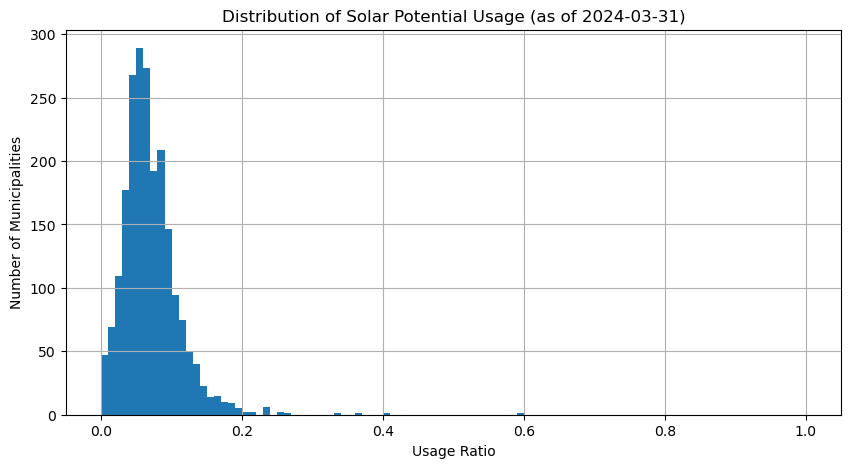

In [63]:
# 8. Visualize distributions
# Filter to March 31, 2024 only
march_df = df_clean[df_clean['energyreporter_date'] == '2024-03-31']
# Use bin edges from 0.00 to 1.00 in steps of 0.01
bins = np.arange(0, 1.01, 0.01)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(march_df["solar_potential_usage"], bins=bins)
plt.title("Distribution of Solar Potential Usage (as of 2024-03-31)")
plt.xlabel("Usage Ratio")
plt.ylabel("Number of Municipalities")
plt.grid(True)
plt.show()

### Observations from the Distribution of Solar Potential Usage
- Most municipalities have very low solar potential usage.
- The distribution is heavily right-skewed, showing underutilization across the country.
- Very few municipalities approached even 40-40% usage.

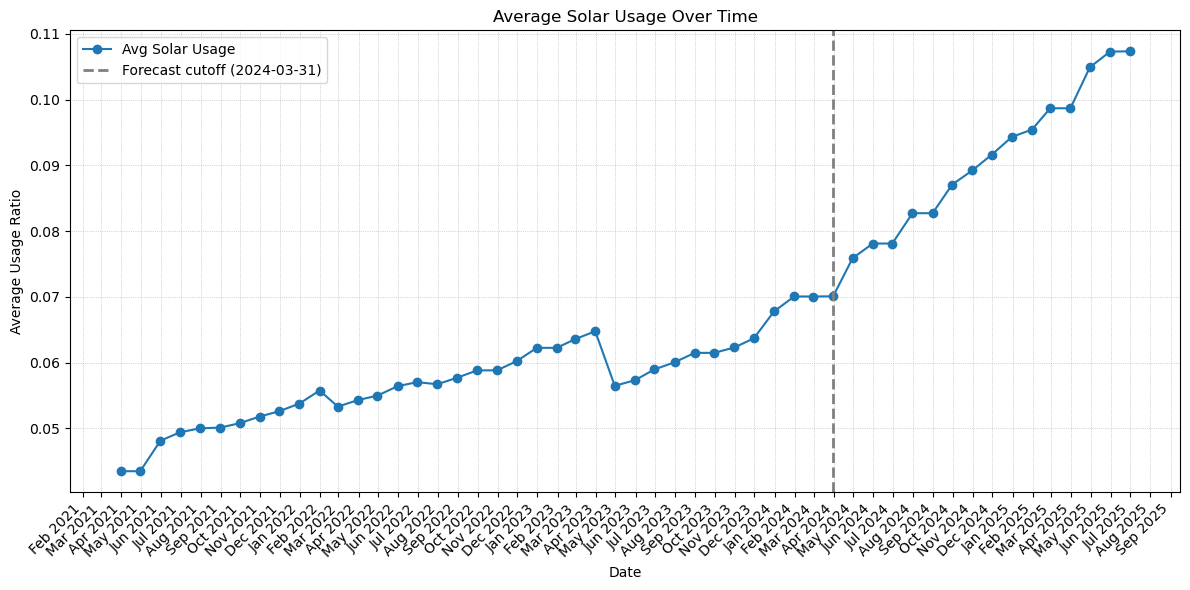

In [64]:
# 9. Growth trends
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Clean up any stray figures
plt.close('all')

# Compute your monthly average if you haven't already
monthly_avg = df_clean.groupby("energyreporter_date")["solar_potential_usage"].mean()

# Create one figure + axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data line
ax.plot(
    monthly_avg.index,
    monthly_avg.values,
    marker='o',
    linestyle='-',
    label="Avg Solar Usage"
)

# Add the vertical cutoff line
cutoff = pd.to_datetime("2024-03-31")
ax.axvline(
    cutoff,
    color="gray",
    linestyle="--",
    linewidth=2,
    label="Forecast cutoff (2024‑03‑31)"
)

# Titles, labels, and grid
ax.set_title("Average Solar Usage Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Average Usage Ratio")
ax.grid(True, which="major", linestyle=":", linewidth=0.5)

# Month‐and‐year tick formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Quarter lines or minor ticks
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
ax.tick_params(which='minor', length=4)

# Legend
ax.legend()

# Draw only once
plt.tight_layout()
plt.show()


### Observations from the Plot:
- From April 2021 to April 2024, the avergae potential usage across municipalities increased to around 7%.
- The trend shows steady growth with some flcutuations.
- The projected values suggest a steeper increase from around 7% to around 10.5%.
- The majoriy of available solar potential across municipalities is still untapped.
- There is a room for growth and policy interventions.

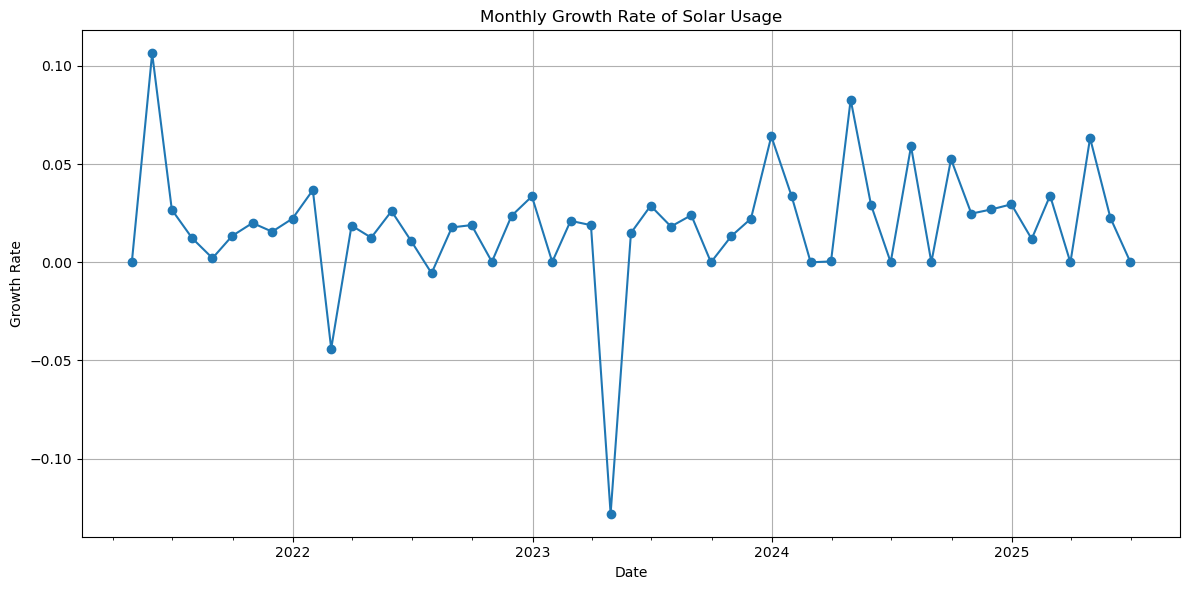

In [65]:
# 9b. Monthly growth rate with x-axis formatting
growth_rate = monthly_avg.pct_change().dropna()
plt.figure(figsize=(12,6))
plt.plot(growth_rate.index, growth_rate.values, marker='o')
plt.title("Monthly Growth Rate of Solar Usage")
plt.xlabel("Date")
plt.ylabel("Growth Rate")
plt.grid(True)
# Improve x-axis date formatting
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
plt.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

### Observations from the monthly growth rate of solar potential usage plot
- The average growth rate is generally positive, indicating that solar potential usage is increasing over time.
- However, month-to-month changes fluctuate significantly, showing no perfectly smooth trajectory. This suggests external influences (e.g., weather, funding cycles, policy impacts).
- There are two sharp negative growth dips, around:
Early 2022
Mid-to-late 2023
These likely indicate data anomalies, reporting gaps, or seasonal effects (e.g., low sunlight months, delayed installations).
- Growth appears consistently positive and stronger starting around Q4 2023.
- There's no major acceleration or slowdown yet, which could suggest current efforts are maintaining the status quo.

In [66]:
# Let's identify moths to investigate further
biggest_drops = growth_rate.sort_values().head(3)
print(biggest_drops)

energyreporter_date
2023-04-30   -0.128009
2022-02-28   -0.043973
2022-07-31   -0.005572
Name: solar_potential_usage, dtype: float64


In [67]:
# Let's compare count of muncipalities per month
municipality_counts = (
    df_clean
     .groupby(df_clean['energyreporter_date'].dt.to_period('M').astype(str))['municipality']
     .nunique()
)

print(municipality_counts.loc[['2023-04', '2022-02', '2022-07']])

energyreporter_date
2023-04    2136
2022-02    2148
2022-07    2145
Name: municipality, dtype: int64


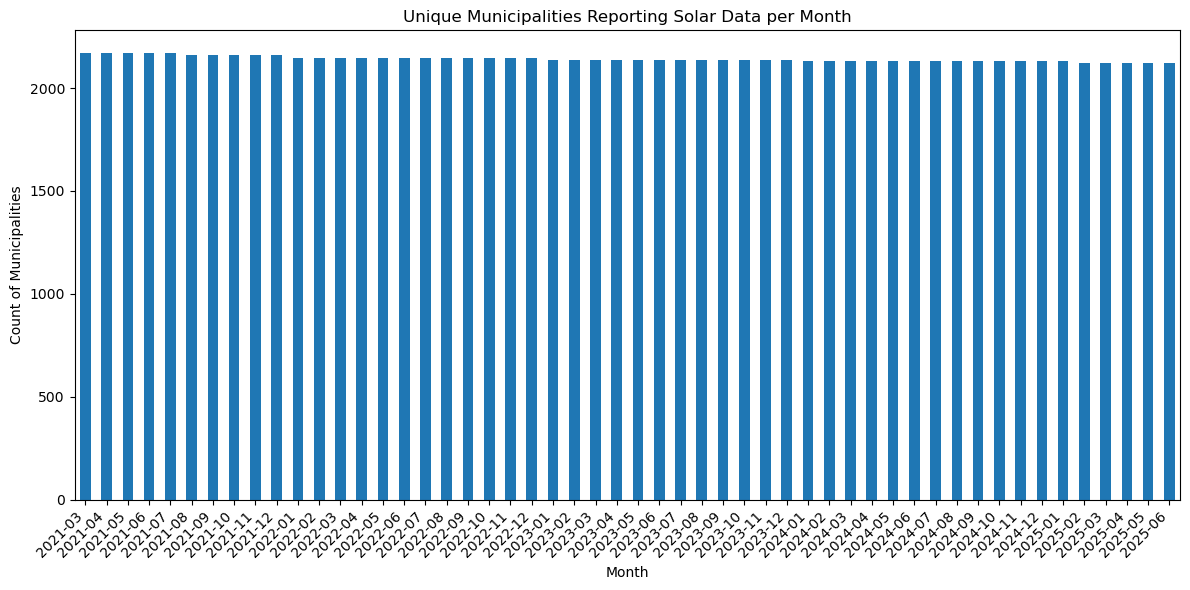

In [68]:
import matplotlib.pyplot as plt

municipality_counts.plot(kind='bar', figsize=(12,6))
plt.title("Unique Municipalities Reporting Solar Data per Month")
plt.xlabel("Month")
plt.ylabel("Count of Municipalities")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Observations
- Every month, including the dips, reports data for the same number of municipalities.
- The observed dips in solar potential usgae are not due to missing data - they are drops in the reported usage ratios, not gaps in reporting coverage.
- Could be: weather effects or seasonal lag, policy/behavior fcators, outliers or aggregation quirks

In [69]:
# A few municipalities may have had extreme values that pulled the avergae down. Let's check the distribution for April 2023, February 2022, and July 2022.
import pandas as pd

# make sure your date column is datetime
solar_df['energyreporter_date'] = pd.to_datetime(solar_df['energyreporter_date'])

months_to_check = ['2022-02', '2022-07', '2023-04']

for month in months_to_check:
    period = pd.Period(month, freq='M')
    mask = solar_df['energyreporter_date'].dt.to_period('M') == period

    print(f"\nStats for {month}")
    print(solar_df.loc[mask, 'solar_potential_usage'].describe())



Stats for 2022-02
count    2148.000000
mean        0.053310
std         0.037964
min         0.000000
25%         0.030799
50%         0.046138
75%         0.068139
max         0.688554
Name: solar_potential_usage, dtype: float64

Stats for 2022-07
count    2145.000000
mean        0.056713
std         0.038853
min         0.000000
25%         0.033322
50%         0.049355
75%         0.071917
max         0.690256
Name: solar_potential_usage, dtype: float64

Stats for 2023-04
count    2136.000000
mean        0.056479
std         0.034946
min         0.000000
25%         0.034991
50%         0.050692
75%         0.070994
max         0.589954
Name: solar_potential_usage, dtype: float64


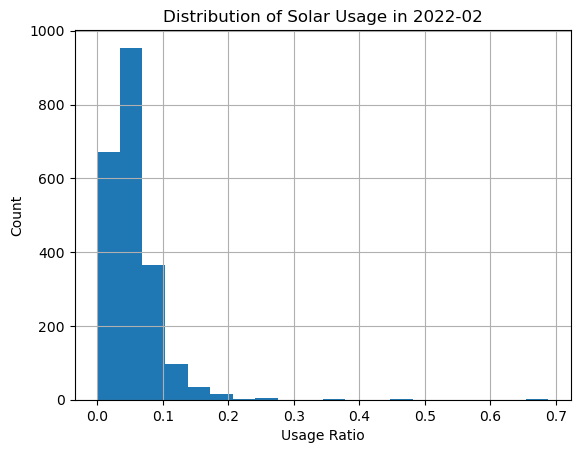

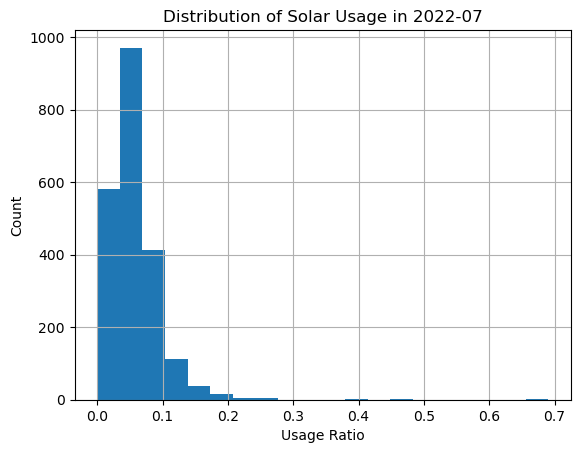

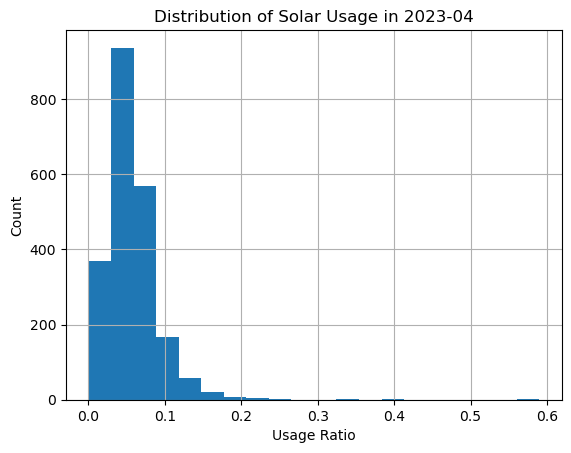

In [70]:
# 9c. Plot distributions for specific months. Plot distributions for specific months. Plot distributions for specific months Plot distributions for specific months Plot distributions for specific months
months_to_plot = ["2022-02", "2022-07", "2023-04"]
for m in months_to_plot:
    # Filter df_clean for the month
    df_month = df_clean[df_clean["energyreporter_date"].dt.strftime('%Y-%m') == m]
    plt.figure()
    plt.hist(df_month["solar_potential_usage"], bins=20)
    plt.title(f"Distribution of Solar Usage in {m}")
    plt.xlabel("Usage Ratio")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()


### Observations
- These dips are not due to missing data, outliers, or anomalies in reporting.
- Rather, they likely reflect actual seasonal variation or slower growth during those months.
- For example, weather, installation slowdowns, or reporting lags.

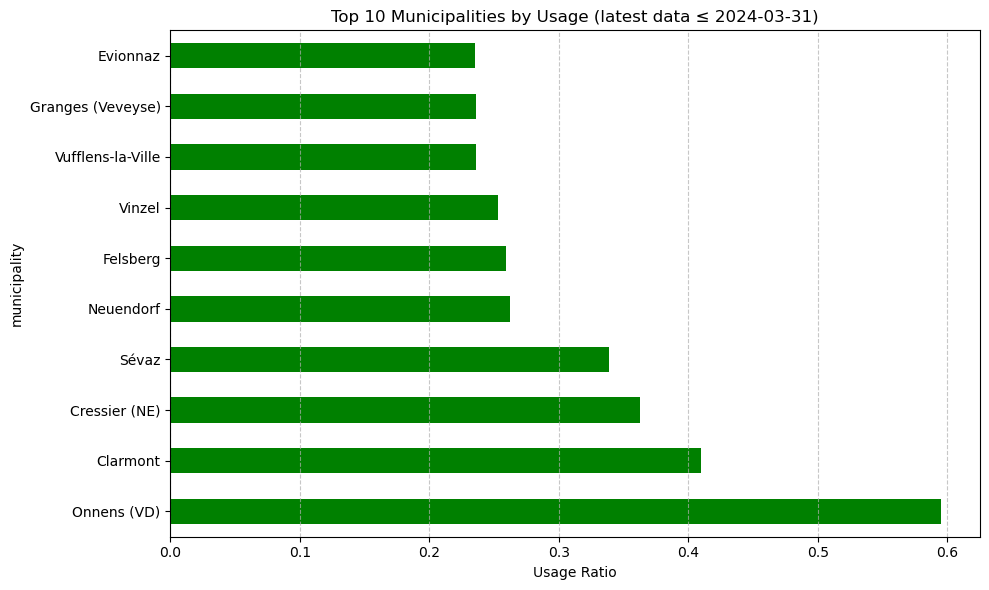

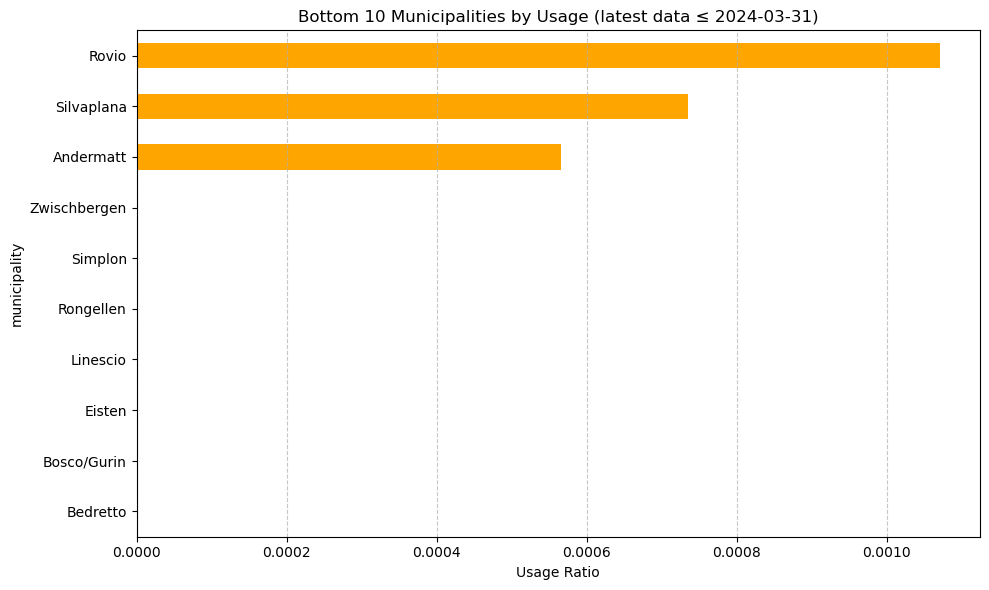

In [71]:
# 10. Rankings as of March 2024 cutoff
cutoff = pd.to_datetime("2024-03-31")

# 1. Filter to actual data up to the cutoff
actual = df_clean[df_clean["energyreporter_date"] <= cutoff]

# 2. Get the latest record per municipality
latest = (
    actual.sort_values("energyreporter_date")
    .groupby("municipality", as_index=False)
    .last()
)

# 3. Identify top and bottom 10 by solar potential usage
top10 = latest.nlargest(10, "solar_potential_usage")
bottom10 = latest.nsmallest(10, "solar_potential_usage")

# 4. Plotting function
def plot_rank(df, title, color):
    plt.figure(figsize=(10,6))
    df.set_index("municipality")["solar_potential_usage"].sort_values(
        ascending=(color!="green")  # green = top10, sort descending
    ).plot(kind="barh", color=color)
    plt.title(title)
    plt.xlabel("Usage Ratio")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 5. Create plots
plot_rank(top10, f"Top 10 Municipalities by Usage (latest data ≤ {cutoff.date()})", "green")
plot_rank(bottom10, f"Bottom 10 Municipalities by Usage (latest data ≤ {cutoff.date()})", "orange")

# 6. Flags for Tableau export
df_clean["is_top10_as_of_mar2024"] = df_clean["municipality"].isin(top10["municipality"])
df_clean["is_bottom10_as_of_mar2024"] = df_clean["municipality"].isin(bottom10["municipality"])

### Observations from Bar Charts on Top and Bottom 10 Municipalities by Solar Potential Usage
- The leading municipality, Onnens (VD), has reached a solar potential usage of nearly 60%, significantly above the national average (~7%).
- Other high performers like Clarmont, Cressier (NE), and Sévaz demonstrate usage levels above 30%, suggesting strong local adoption or effective policy/incentive structures.
- These top municipalities serve as case studies for what’s achievable in solar adoption at the local level.
- The majority of bottom-ranking municipalities show zero or near-zero usage of their solar potential.
- Only 3 municipalities in the bottom 10 (e.g., Binn, Silvaplana, Andermatt) show non-zero usage, and even those are below 0.1% — indicating vast underutilization.
- Most bottom performers are located in remote alpine or low-density regions, which may face infrastructure, economic, or climatic barriers.

In [72]:
# 11. High-capacity, low-usage cohort
metrics_last = actual.groupby("municipality")[
    ["solar_potential_usage","solar_power_installed_kwp"]
].last()
hplu = metrics_last[(metrics_last["solar_potential_usage"] < 0.05) & (metrics_last["solar_power_installed_kwp"] > 1000)]
hplu_top10 = hplu.nlargest(10, "solar_power_installed_kwp").reset_index()

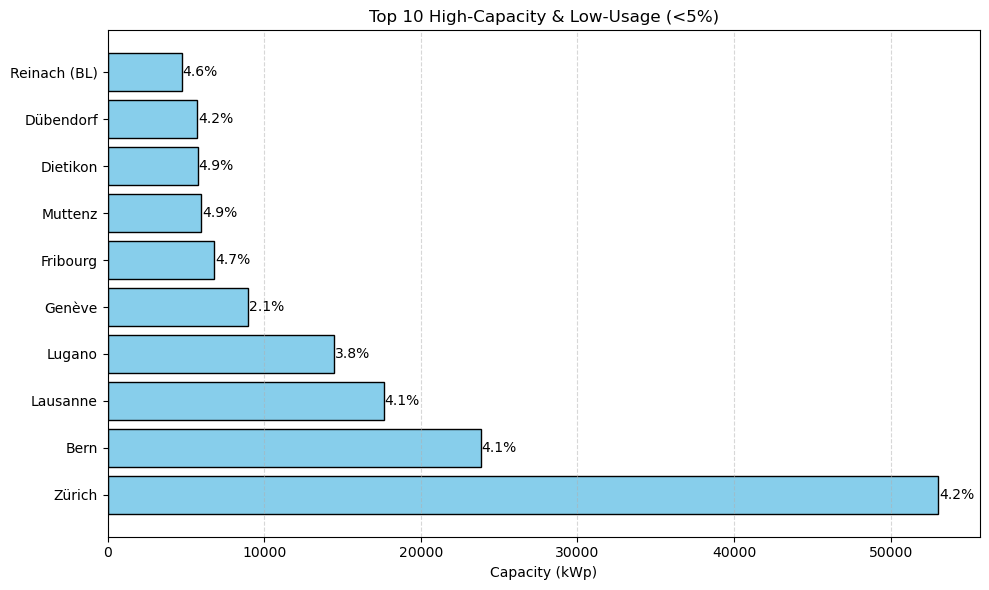

In [73]:
# 11a. Simple bar
plt.figure(figsize=(10,6))
bars = plt.barh(hplu_top10["municipality"], hplu_top10["solar_power_installed_kwp"], color="skyblue", edgecolor="black")
for bar, usage in zip(bars, hplu_top10["solar_potential_usage"]):
    plt.text(bar.get_width()+50, bar.get_y()+bar.get_height()/2, f"{usage:.1%}", va='center')
plt.title("Top 10 High-Capacity & Low-Usage (<5%)")
plt.xlabel("Capacity (kWp)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Observations from the DataFrame for high potential low usage municipalities (loosend threshold)
- These are large urban centers or economically active municipalities, where uptake of solar lags behind capacity.
- Even though they’ve already installed thousands of kWp, they’ve tapped into only ~4–5% of their full solar potential.
- Cities like Zürich, Bern, and Geneva are particularly important: their absolute potential is so large that even modest increases in usage could move national averages.

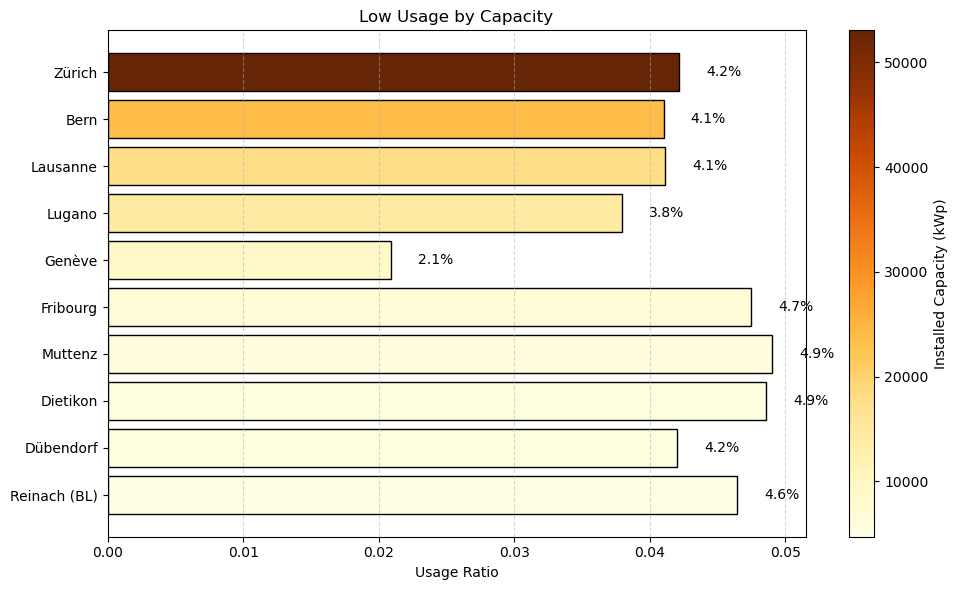

In [74]:
# 11b. Colored bar
plot_df = hplu_top10.sort_values("solar_power_installed_kwp")
norm = colors.Normalize(vmin=plot_df["solar_power_installed_kwp"].min(), vmax=plot_df["solar_power_installed_kwp"].max())
cmap = plt.colormaps['YlOrBr']
bar_colors = [cmap(norm(v)) for v in plot_df["solar_power_installed_kwp"]]
fig, ax = plt.subplots(figsize=(10,6))
bars = ax.barh(plot_df["municipality"], plot_df["solar_potential_usage"], color=bar_colors, edgecolor="black")
for bar, usage in zip(bars, plot_df["solar_potential_usage"]):
    ax.text(bar.get_width()+0.002, bar.get_y()+bar.get_height()/2, f"{usage:.1%}", va='center', ha='left')
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Installed Capacity (kWp)")
ax.set_title("Low Usage by Capacity")
ax.set_xlabel("Usage Ratio")
ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

df_clean["is_high_capacity_low_usage"] = df_clean["municipality"].isin(hplu_top10["municipality"])

### Observations from the plot of the low usage municipalities colored by installed solar capacity
- Zürich stands out with the darkest bar (most installed kWp: ~53,000). Yet its usage ratio is only ~4.2%, indicating major untapped potential.
- Bern and Lausanne follow Zürich, with similarly low usage rates (~4.1%).
- Lugano and Genève also have significant installed capacity but low efficiency (~2.1% for Genève).
-  These large urban municipalities might face administrative, architectural, or grid integration challenges that limit efficient solar deployment.
-  Despite large investments in infrastructure (yellow to brown bars), many municipalities remain below 5% usage.
-  This visual mismatch suggests an opportunity for policy interventions, incentives, or awareness campaigns.
-  Mid-sized municipalities like Muttenz, Dietikon, and Reinach (BL) have better usage (~4.6%–4.9%) compared to their installed base.
-  These could serve as role models or case studies for others.
-  Most municipalities are below 0.05 (5%) usage despite major installed infrastructure.
-  The left-heavy bar lengths + dark shading clearly tell the story of “plenty of hardware, not enough usage.

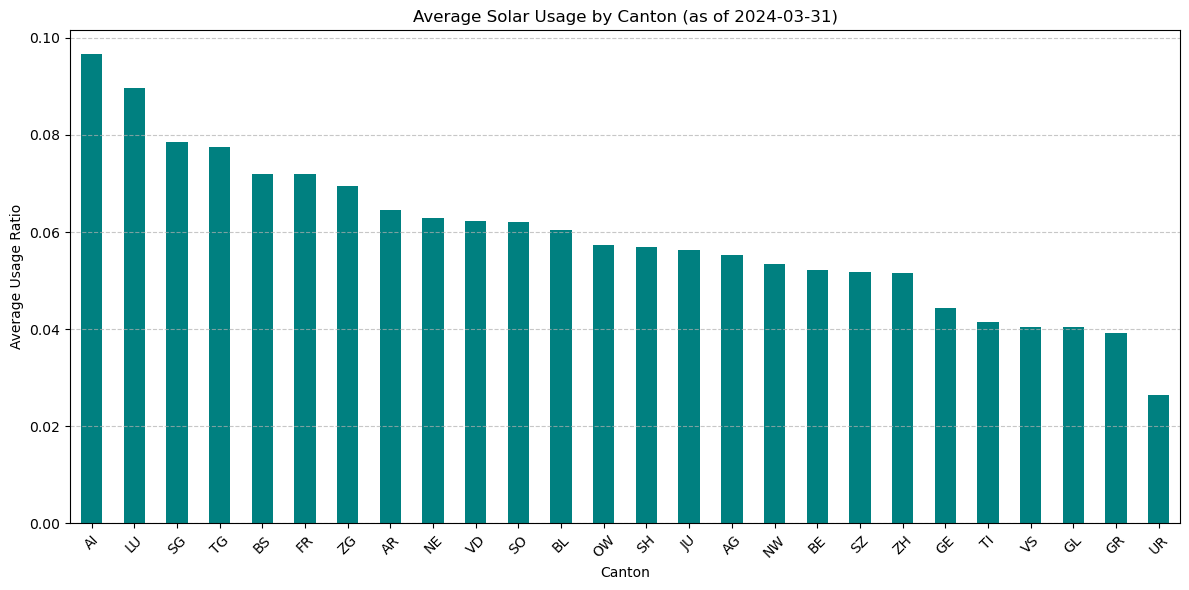

In [75]:
# 12. Visualize solar potential usage by canton
# Compute latest metrics per canton
canton_metrics = (
    actual
    .groupby("canton")["solar_potential_usage"]
    .mean()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12,6))
canton_metrics.plot(kind="bar", color="teal")
plt.title(f"Average Solar Usage by Canton (as of {latest_dt.date()})")
plt.xlabel("Canton")
plt.ylabel("Average Usage Ratio")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [76]:
# Define the cutoff date
cutoff_date = pd.Timestamp("2024-03-31")

# Filter for projected entries
projected_df = df_clean[df_clean['energyreporter_date'] > cutoff_date]

# Number of unique municipalities with projected data
num_projected_municipalities = projected_df['municipality'].nunique()
print("Municipalities with projected data:", num_projected_municipalities)



Municipalities with projected data: 2133


In [77]:
total_municipalities = df_clean['municipality'].nunique()
print("Total municipalities:", total_municipalities)


Total municipalities: 2184


In [78]:
# Get the latest date for each municipality
latest_date_per_muni = df_clean.groupby('municipality')['energyreporter_date'].max().reset_index()
latest_date_per_muni.columns = ['municipality', 'latest_date']

# Merge with the original dataframe to check if latest date is projected
merged_df = pd.merge(df_clean, latest_date_per_muni, on='municipality')
merged_df['is_latest_projected'] = merged_df['energyreporter_date'] == merged_df['latest_date']
merged_df['is_projection'] = merged_df['energyreporter_date'] > cutoff_date

# Now count how many municipalities have their latest date as projected
latest_projected_muni = merged_df[merged_df['is_latest_projected'] & merged_df['is_projection']]['municipality'].nunique()
print("Municipalities with latest date as projected:", latest_projected_muni)

Municipalities with latest date as projected: 2133


### Observations from the solar potential usage by canton chart
- Appenzell Innerrhoden (AI) leads the country with 11.4% solar potential usage.
- Lucerne (LU) and Thurgau (TG) follow closely with above 9% usage.
- Most cantons lie between 6% to 8.5% usage.
- Geneva (GE), Graubünden (GR), and Uri (UR) are at the bottom — all below 5%.
- These cantons have untapped solar potential, possibly due to urban density, heritage constraints, or limited local incentives.

In [82]:
# 13. Export unified DataFrame for Tableau
import os
os.makedirs("data", exist_ok=True)

export_path = "data/solar_municipality_unified1.csv"
df_clean.to_csv(export_path, index=False)
abs_path = os.path.abspath(export_path)
print(f"Exported unified CSV to: {export_path}")
print(f"Absolute path on disk: {abs_path}")

Exported unified CSV to: data/solar_municipality_unified1.csv
Absolute path on disk: C:\Users\peter\data\solar_municipality_unified1.csv


In [84]:
!pip install geopandas

   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   ---- ----------------------------------- 2.4/19.2 MB 11.6 MB/s eta 0:00:02
   --------- ------------------------------ 4.7/19.2 MB 11.6 MB/s eta 0:00:02
   -------------- ------------------------- 7.1/19.2 MB 11.5 MB/s eta 0:00:02
   ------------------- -------------------- 9.4/19.2 MB 11.5 MB/s eta 0:00:01
   ------------------------ --------------- 11.8/19.2 MB 11.5 MB/s eta 0:00:01
   ----------------------------- ---------- 14.2/19.2 MB 11.5 MB/s eta 0:00:01
   ---------------------------------- ----- 16.5/19.2 MB 11.5 MB/s eta 0:00:01
   ---------------------------------------  18.9/19.2 MB 11.5 MB/s eta 0:00:01
   ---------------------------------------- 19.2/19.2 MB 11.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ------------- -------------------------- 2.1/6.3 MB 11.6 MB/s eta 0:00:01
   ---------------------------- ----------- 4.5/6.3 MB 11.5 MB/s eta 0:00:01


In [99]:
import geopandas as gpd
import pandas as pd
import os

import geopandas as gpd
import pandas as pd
import os

# Define shapefile path
shp_path = r"C:\Users\peter\OneDrive\Рабочий стол\Portfolio Project 1\data\Geo Data\swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"

# Read the shapefile (in EPSG:2056)
gdf = gpd.read_file(shp_path)

# Compute centroids in original CRS (EPSG:2056)
gdf["centroid"] = gdf.geometry.centroid

# Reproject centroids to WGS84
gdf = gdf.set_geometry("centroid")
gdf = gdf.to_crs(epsg=4326)

# Extract coordinates
gdf["Latitude"] = gdf.geometry.y
gdf["Longitude"] = gdf.geometry.x

# Restore polygon geometry
gdf = gdf.set_geometry("geometry")

# Map canton number to official abbreviations
knum_to_code = {
    1: "ZH", 2: "BE", 3: "LU", 4: "UR", 5: "SZ", 6: "OW", 7: "NW", 8: "GL", 9: "ZG",
    10: "FR", 11: "SO", 12: "BS", 13: "BL", 14: "SH", 15: "AR", 16: "AI", 17: "SG",
    18: "GR", 19: "AG", 20: "TG", 21: "TI", 22: "VD", 23: "VS", 24: "NE", 25: "GE", 26: "JU"
}

gdf["Canton"] = gdf["KANTONSNUM"].map(knum_to_code)

# Export
os.makedirs("data", exist_ok=True)
output_path = "data/cantons_with_coords.csv"
gdf[["Canton", "Latitude", "Longitude"]].to_csv(output_path, index=False)

print("Exported to:", os.path.abspath(output_path))


Exported to: C:\Users\peter\data\cantons_with_coords.csv
